In [1]:
# 读取数据
import random
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import compute_class_weight
from keras.regularizers import l1,l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

['c:\\Users\\31717\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\31717\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\cv2', 'c:\\Users\\31717\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'c:\\Users\\31717\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'c:\\Users\\31717\\AppData\\Local\\Programs\\Python\\Python312', '', 'C:\\Users\\31717\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\31717\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\31717\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\31717\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'c:\\Users\\31717\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages']


In [2]:
#读取数据
def read_data(file_path):
    data = pd.read_csv(file_path,index_col="sample_id")
    if 'label' in data.columns:
        y = data['label']
        return data, y
    else:
        return data, None

In [3]:
#导入文件
file_path_train = r'D:\code\Software-Cup\Software-Cup\python\data\train_10000.csv'
file_path_val = r'D:\code\Software-Cup\Software-Cup\python\data\validate_1000.csv'
df,y = read_data(file_path_train)
df_val,y_val = read_data(file_path_val)

In [4]:
#分析数据
def data_analysis(data,y):

    # 设置绘图风格
    sns.set(style="darkgrid")   
    # 绘制类别分布图
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = ['SimHei']
    ax = sns.countplot(x=y)
    ax.set_title('故障分布')
    plt.xlabel('类别')
    plt.ylabel('个数')
    plt.show()
    # 获取数据集中的所有特征列
    warnings.filterwarnings('ignore')
    data = data.drop(y.name, axis=1)
    features = data.columns
    plot_features = random.sample(list(features), k=1)
    # 遍历每个特征
    for feature in plot_features:
        data = data.reset_index(drop=True)
        # 绘制概率密度图
        sns.kdeplot(data[feature], fill=True)
        plt.title(f'{feature} 概率密度函数')
        plt.xlabel(feature)
        plt.ylabel('概率密度')
        plt.show()
    data = pd.concat([data, y], axis=1)


    # 计算相关系数矩阵
    corr = data.corr()
    # 绘制热力图
    plt.figure(figsize=(100,100))
    sns.heatmap(corr, cmap='coolwarm', annot=True)
    plt.show()


    return

In [5]:
#特征分析
#data_analysis(df,y)

In [6]:
#删除重复值
def remove_duplicates(data, y):
    data = data.drop_duplicates()
    y = y.loc[data.index]
    return data, y

In [7]:
#删除重复值
df,y = remove_duplicates(df,y)

In [8]:
#删除无用特征列
def drop_features(data):
    features_to_drop = ['feature57', 'feature77', 'feature100', 'feature92', 'feature88', 'feature65', 'feature54'
                        , 'feature80', 'feature1', 'feature60', 'feature32', 'feature78', 'feature20'] # 在这里定义要删除的特征名称列表
    data = data.drop(features_to_drop, axis=1)
    return data

In [9]:
#运行删除无用列函数
df = drop_features(df)
df_val = drop_features(df_val)

In [10]:
#填充缺失值
def fill_missing_values_knn(data):
    if 'label' in data.columns:
        data = data.drop('label', axis=1)
    # 使用KNNImputer填充缺失值
    #imputer = KNNImputer(n_neighbors = 42, weights = 'distance')
    imputer = KNNImputer(n_neighbors = 43, weights = 'distance')
    data_filled = imputer.fit_transform(data)
    # 将填充后的数据转换为DataFrame
    data = pd.DataFrame(data_filled, columns=data.columns, index=data.index)
    #data.to_csv('output.csv', index=True)
    return data

In [11]:
#运行填充缺失值函数
df = fill_missing_values_knn(df)
df_val = fill_missing_values_knn(df_val)

In [12]:
#数据标准化
def scale_data(data):
    # 进行数据标准化
    scaler = StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    #data.to_csv('output.csv', index=True)
    return data

In [13]:
#标准化数据集
df = scale_data(df)
df_val  = scale_data(df_val)

In [14]:
#模型构建及训练
def train_model(X_train, y_train, X_val = None, y_val = None):

    if X_val is  None or y_val is  None:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
        
    # 计算类别权重
    class_weights = compute_class_weight(class_weight='balanced',classes= np.unique(y_train),y = y_train)
    class_weights = dict(enumerate(class_weights))
    
    # 构建模型
    model = Sequential()
    model.add(Dense(94, activation='tanh', input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.01)))
    model.add(Dense(282, activation='tanh',kernel_regularizer=l2(0.01)))
    model.add(Dense(252, activation='tanh',kernel_regularizer=l2(0.01)))
    model.add(Dense(42, activation='tanh',kernel_regularizer=l2(0.01)))
    model.add(Dense(6, activation='softmax'))

    
    # 编译模型
    model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])

    # 将标签数据转换为独热编码
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)

    # 训练模型
    history = model.fit(X_train,y_train, epochs= 312, batch_size= 1234,class_weight=class_weights, validation_data=(X_val, y_val))
    
    # 绘制训练损失和验证损失
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # 绘制训练准确率和验证准确率
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    
    # 在验证集上评估模型性能并输出分类报告
    y_pred = model.predict(X_val)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_val.argmax(axis=1)
    print(classification_report(y_true, y_pred))

    # X的混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    # 绘制热力图
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # 设置坐标轴标签
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')


    # 生成唯一的模型名称
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"dnn_model_{timestamp}.h5"

    # 保存模型
    #model.save(model_name)

    return model_name

Epoch 1/312


c:\Users\31717\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.3315 - loss: 13.9395 - val_accuracy: 0.6390 - val_loss: 13.1656
Epoch 2/312
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5079 - loss: 12.8903 - val_accuracy: 0.7120 - val_loss: 12.3930
Epoch 3/312
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5883 - loss: 12.1710 - val_accuracy: 0.7440 - val_loss: 11.7576
Epoch 4/312
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6382 - loss: 11.5525 - val_accuracy: 0.7570 - val_loss: 11.1850
Epoch 5/312
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6638 - loss: 10.9911 - val_accuracy: 0.7680 - val_loss: 10.6564
Epoch 6/312
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6768 - loss: 10.4736 - val_accuracy: 0.7750 - val_loss: 10.1681
Epoch 7/312
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6990 - loss: 9.9944 - val_accuracy: 0.7910 - val_loss: 9.7105
Epoch 8/312
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7186 - loss: 9.5437 - val_accuracy: 0.7920 - val_loss:

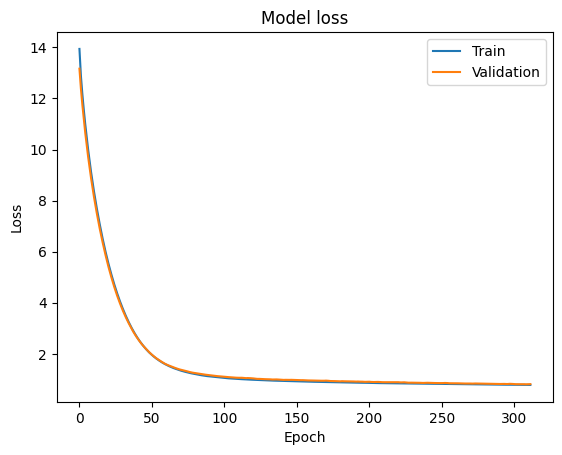

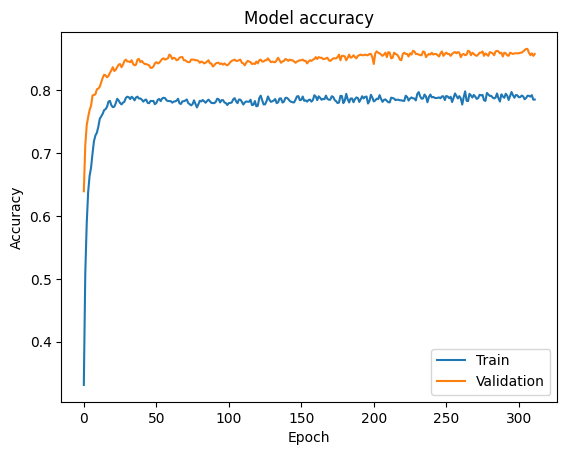

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       176
           1       0.70      0.61      0.66       166
           2       0.68      0.74      0.71       171
           3       0.98      0.97      0.97       169
           4       0.94      0.98      0.96       156
           5       0.98      0.98      0.98       162

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



'dnn_model_20251029_102300.h5'

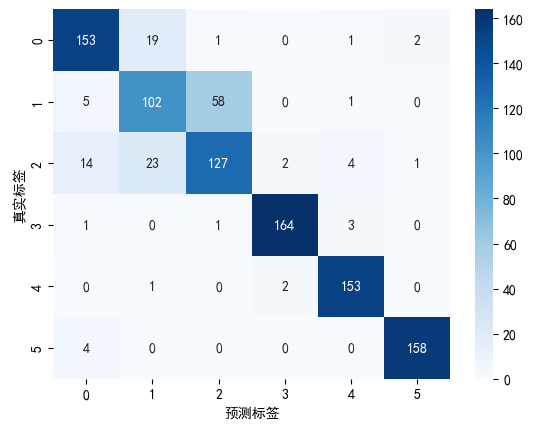

In [15]:
#模型训练
train_model(df,y,df_val,y_val)